<a href="https://colab.research.google.com/github/Sachin270/CMLAssignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [30]:
!ls /content/drive/'MyDrive'/'Colab Notebooks'/

'Assignment2 (1).ipynb'		      patch_images
 Assignment2.ipynb		      Untitled
 Assignment2_s3714805.ipynb	      Untitled0.ipynb
 CMLAssignment2-main.zip	      Untitled1.ipynb
 data_labels_extraData.csv	      Untitled2.ipynb
 data_labels_mainData.csv	     'Untitled8 (1).ipynb'
'Image_classification_data (1).zip'   Untitled8.ipynb


In [3]:
!cp /content/drive/'MyDrive'/'Colab Notebooks'/'Image_classification_data (1).zip' .
!unzip -q -o 'Image_classification_data (1).zip'
!rm 'Image_classification_data (1).zip'
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.layers import Dense

In [5]:
data = pd.read_csv('./data_labels_mainData.csv')
OUTPUT_CLASSES = 4
data.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

# New Section

In [6]:
data.groupby('cellTypeName').agg('count')

,InstanceID,patientID,ImageName,cellType,isCancerous
cellTypeName,,,,,
epithelial,4079,4079,4079,4079,4079
fibroblast,1888,1888,1888,1888,1888
inflammatory,2543,2543,2543,2543,2543
others,1386,1386,1386,1386,1386


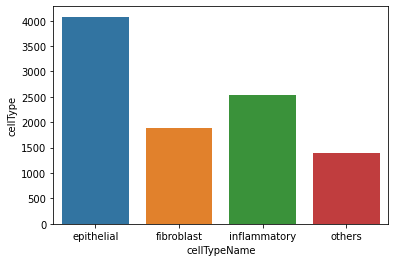

In [7]:
sns.barplot(x=data.groupby('cellTypeName').agg('count').index, 
            y='cellType', 
            data=data.groupby('cellTypeName').agg('count'))

In [8]:
data.groupby('isCancerous').agg('count')

,InstanceID,patientID,ImageName,cellTypeName,cellType
isCancerous,,,,,
0,5817,5817,5817,5817,5817
1,4079,4079,4079,4079,4079


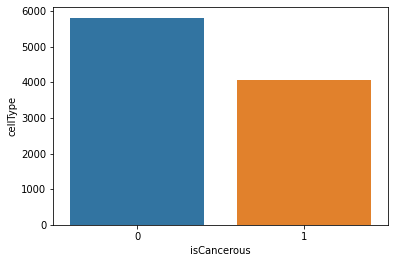

In [9]:
sns.barplot(x=data.groupby('isCancerous').agg('count').index, 
            y='cellType', 
            data=data.groupby('isCancerous').agg('count'))

In [10]:
data.groupby(['cellTypeName', 'isCancerous']).agg('count')

,,InstanceID,patientID,ImageName,cellType
cellTypeName,isCancerous,,,,
epithelial,1,4079,4079,4079,4079
fibroblast,0,1888,1888,1888,1888
inflammatory,0,2543,2543,2543,2543
others,0,1386,1386,1386,1386


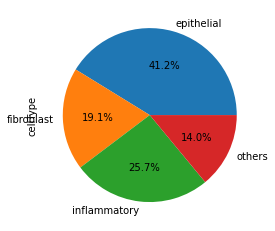

In [11]:
data.groupby('cellTypeName').agg('count').cellType.plot.pie(autopct="%.1f%%")

In [12]:
extraData = pd.read_csv('data_labels_extraData.csv')
extraData.columns

Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')

In [13]:
mergedData = pd.concat([data[["InstanceID", "patientID", "ImageName", "isCancerous"]], extraData])

In [14]:
OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(mergedData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [15]:
train_data['Class'] = train_data['isCancerous'].astype('str')
val_data['Class'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [16]:
import tensorflow as tf
reg_lambda = 0.0001

modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])

    plt.show()

In [17]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [ ]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator, epochs=100)

In [ ]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

In [29]:
modelCancerous.save("model_VGG_3")
!cp -R ./modelCancerous/content/drive/'MyDrive'/'Colab Notebooks'

INFO:tensorflow:Assets written to: model_VGG_3/assets
cp: missing destination file operand after './content/drive/MyDrive/Colab Notebooks/modelCancerous'
Try 'cp --help' for more information.


In [ ]:
modelCancerous.summary()

In [ ]:
modelCancerous.pop()

In [ ]:
modelCancerous.summary()

In [ ]:
modelCancerous.add(Dense(4, activation='softmax'))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

In [ ]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history_VGG_3 = modelCancerous.fit(train_generator, validation_data = validation_generator, epochs=100)

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [ ]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')



train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 50

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25)

Epoch 1/25
119/119 [==============================] - 33s 33ms/step - loss: 1.0897 - sparse_categorical_accuracy: 0.5333 - val_loss: 1.0134 - val_sparse_categorical_accuracy: 0.6028
Epoch 2/25
119/119 [==============================] - 3s 28ms/step - loss: 0.8135 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.7023 - val_sparse_categorical_accuracy: 0.7196
Epoch 3/25
119/119 [==============================] - 3s 28ms/step - loss: 0.7648 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.7381 - val_sparse_categorical_accuracy: 0.7014
Epoch 4/25
119/119 [==============================] - 3s 29ms/step - loss: 0.6877 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.7473
Epoch 5/25
119/119 [==============================] - 3s 29ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.7393
Epoch 6/25
119/119 [==============================] - 3s 29ms/step - loss: 0.6512 - sparse_cat

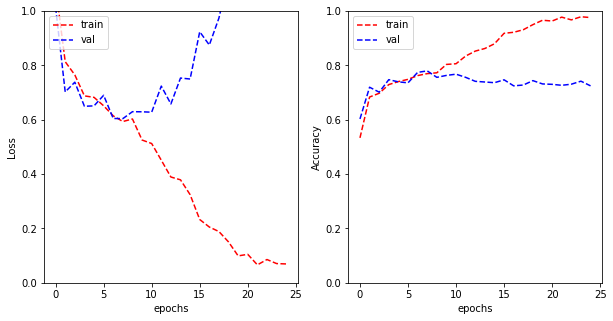

In [ ]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['sparse_categorical_accuracy'], history_VGG_1.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=100)
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['sparse_categorical_accuracy'], history_VGG_2.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_2.evaluate(validation_generator)

40/40 [==============================] - 1s 19ms/step - loss: 1.4398 - sparse_categorical_accuracy: 0.7458


[1.4398329257965088, 0.7458312511444092]

In [ ]:
test_data['Class'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.7283


[1.578864574432373, 0.7282828092575073]

In [ ]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
import tensorflow as tf
reg_lambda = 0.00001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:

model_VGG_3.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model_VGG_3.optimizer.get_config()

In [ ]:
history_VGG_3 = model_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=100)

In [ ]:
plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['sparse_categorical_accuracy'], history_VGG_3.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_3.evaluate(validation_generator)

74/74 [==============================] - 1s 11ms/step - loss: 0.7381 - sparse_categorical_accuracy: 0.7433


[0.7381166815757751, 0.7433046698570251]

In [ ]:
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

In [ ]:
OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(mergedData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [ ]:
train_data['Class'] = train_data['isCancerous'].astype('str')
val_data['Class'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
reg_lambda = 0.0001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
model_VGG_3.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG_3 = model_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=100)

In [ ]:
plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9137693078479194
F1 score:  0.9092785580010481
[[30050  1201]
 [ 3360 18282]]


In [ ]:
model_VGG_3.save("model_VGG_3")

INFO:tensorflow:Assets written to: model_VGG_3/assets


In [ ]:
## Only on colab
# Change according to your directory structure
!cp -R ./model_VGG_3 /content/drive/'MyDrive'/'Colab Notebooks'/

In [ ]:
#Uncomment if on loca machine or AWS
# import zipfile
# with zipfile.ZipFile('./Image_classification_data (1).zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4


# Uncomment the following line to do two class classification with
# a subset of data
# data = data[(data['Class'] == 3) | (data['Class'] == 5)]
# OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [ ]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 50

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
modelCancerous.summary()

In [23]:
from tensorflow.keras.layers import Dense
modelCancerous.pop()

In [ ]:
modelCancerous.summary()

In [26]:
modelCancerous.add(Dense(4, activation='softmax'))

In [ ]:
model_VGG_3.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history_VGG_3 = model_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=100)